In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps

## Funciones

In [2]:
def open_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error al abrir el video")
        exit()
    return cap

def get_video_frames(cap, num_frames = None):
    if not num_frames: num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            print(f"Error al leer el fotograma {i + 1}")
            break
        frames.append(frame)
    cap.release()
    return frames

def frame_imshow_vis(image, tit = 'image'):
    cv2.imshow(tit, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def frame_plt_vis(image, fsize = (8, 8)):
    f, ax = plt.subplots(figsize=fsize)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    return ax

def obtain_temp(image):
    temp = np.mean(image)
    return -(100/255)*temp+100

def get_colors_to_gray(colors_n, vis=False):
    cmap = colormaps["jet"]
    gray_values = np.linspace(0, 255, colors_n, dtype=int)
    jet_colors = (cmap(gray_values)[:,:3]*255).astype(int)
    color_to_gray_map = dict(zip(map(tuple, jet_colors), gray_values))

    if vis:
        colors_normalized = jet_colors / 255.0
        x = np.arange(len(jet_colors))
        y = np.ones(len(jet_colors))
        plt.figure(figsize=(10, 2))
        plt.scatter(x, y, color=colors_normalized, s=500)  # s is the size of the points
        plt.axis('off')
        plt.show()
    return color_to_gray_map

def closest_color(pixel_color, colors_to_gray):
    colors = list(colors_to_gray.keys())
    distances = np.sqrt(np.sum((np.array(colors) - np.array(pixel_color))**2, axis=1))
    closest_index = np.argmin(distances)
    return list(colors_to_gray.values())[closest_index]

def closest_color(pixel_color, colors_to_gray):
    colors = list(colors_to_gray.keys())
    distances = np.sqrt(np.sum((np.array(colors) - np.array(pixel_color))**2, axis=1))
    closest_index = np.argmin(distances)
    return list(colors_to_gray.values())[closest_index]

def get_gray_scale_image(image, colors_to_gray):
    out_im = np.zeros(image.shape[:2], dtype=np.uint8)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_color = tuple(image[y, x])
            gray_value = closest_color(pixel_color, colors_to_gray)
            out_im[y, x] = gray_value
    return out_im

def crop_image(image, x_range, y_range, vis = False):
    if np.mean(x_range) < 1:
        x_min, x_max = int(image.shape[:2][1]*x_range[0]), int(image.shape[:2][1]*x_range[1])
        y_min, y_max = int(image.shape[:2][0]*y_range[0]), int(image.shape[:2][0]*y_range[1])
    else:
        x_min, x_max = x_range
        y_min, y_max = y_range
    c_image = image[y_min:y_max, x_min:x_max]
    if vis:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), facecolor='.85')
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        rectangle = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='black', facecolor='none') # bottom left corner | w, h
        ax1.add_patch(rectangle)

        ax2.imshow(cv2.cvtColor(c_image, cv2.COLOR_BGR2RGB))
        ax2.set_xticks([])
        ax2.set_yticks([])
        plt.tight_layout()
        plt.show()
        pass

    return c_image

## Abrir video

In [3]:
cap = open_video('video_prueba_2.wmv')
frames = get_video_frames(cap, num_frames = None)

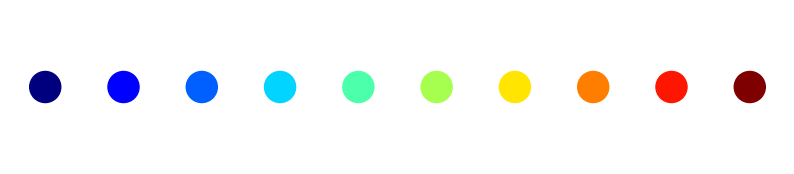

In [4]:
colors_to_gray = get_colors_to_gray(10, True)

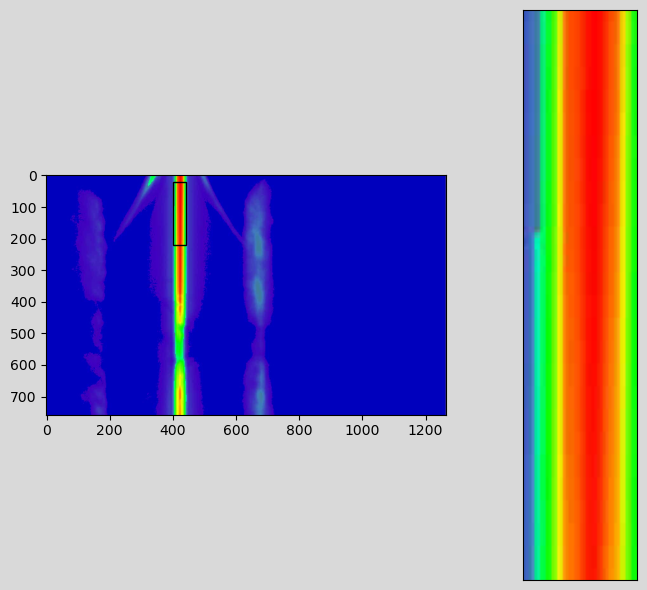

In [5]:
image = frames[0]
xycoord = (400, 20)
w ,h = 40, 200
cropped_image = crop_image(image, [400,440], [20, 220], True)

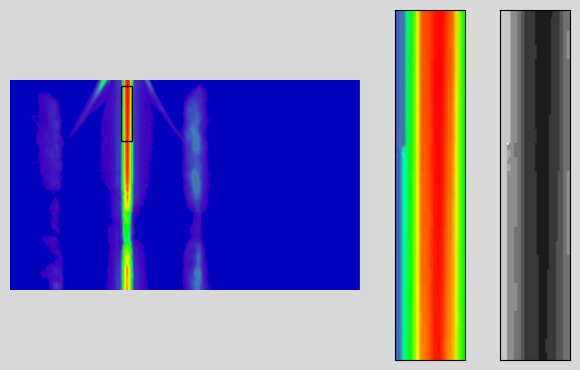

In [6]:
image = frames[0]
xycoord = (400, 20)
w ,h = 40, 200
cropped_image = image[xycoord[1]:xycoord[1]+h, xycoord[0]:xycoord[0]+w]

out_im = get_gray_scale_image(cropped_image, colors_to_gray)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 6), facecolor='.85')

ax1.set_position([0.05, 0.05, 0.5, 0.9])  # (left, bottom, width, height)
ax2.set_position([0.6, 0.05, 0.1, 0.9])   
ax3.set_position([0.75, 0.05, 0.1, 0.9])   

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
rectangle = patches.Rectangle(xycoord, w, h, linewidth=1, edgecolor='black', facecolor='none') # bottom left corner | w, h
ax1.add_patch(rectangle)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(cv2.cvtColor(out_im, cv2.COLOR_BGR2RGB))
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

In [7]:
temps = []
for frame in frames:
    cropped_image = frame[xycoord[1]:xycoord[1]+h, xycoord[0]:xycoord[0]+w]
    out_im = get_gray_scale_image(cropped_image, colors_to_gray)
    temps.append(obtain_temp(out_im))

In [8]:
def vis_prop_w_mov_av(data, wdw, ylims=None):
    if isinstance(data, list): data = np.array(data)
    mov_av = np.convolve(np.array(data), np.ones(wdw)/wdw, mode='valid')
    range_x = np.arange(len(mov_av)) + (wdw//2)
    f, ax = plt.subplots(figsize=(8, 8))
    ax.plot(data, alpha=.2)
    ax.plot(range_x, mov_av, color='black')
    if ylims: ax.set_ylim(ylims)
    plt.show()

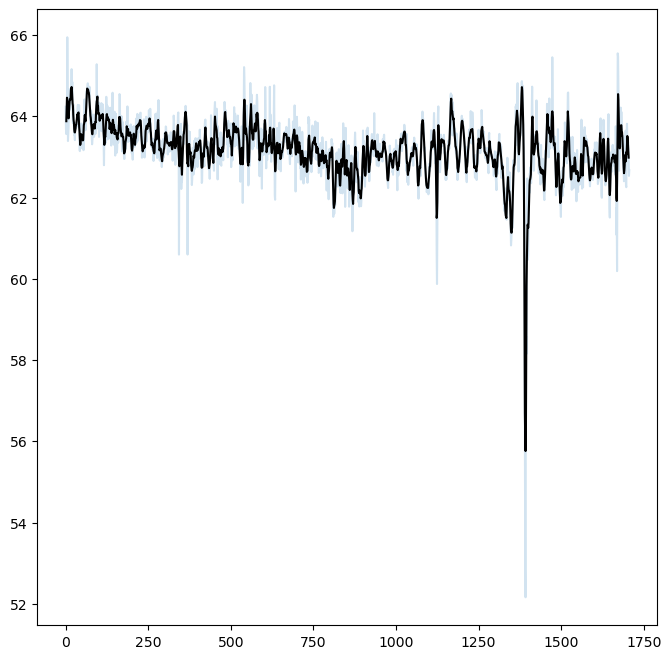

In [10]:
# %matplotlib tk
# %matplotlib inline
vis_prop_w_mov_av(temps,5, ylims=None)

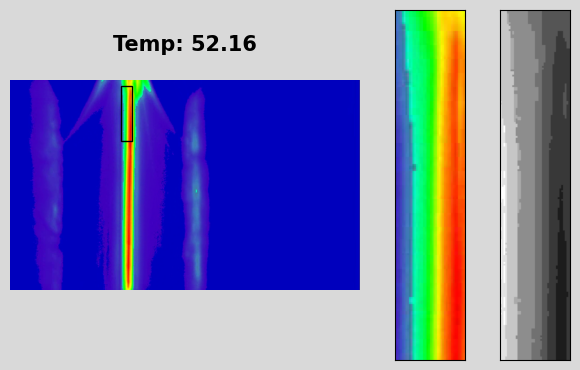

In [13]:
idn = np.argmin(np.array(temps))

image = frames[idn+0]
xycoord = (400, 20)
w ,h = 40, 200
cropped_image = image[xycoord[1]:xycoord[1]+h, xycoord[0]:xycoord[0]+w]

out_im = get_gray_scale_image(cropped_image, colors_to_gray)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 6), facecolor='.85')

ax1.set_position([0.05, 0.05, 0.5, 0.9])  # (left, bottom, width, height)
ax2.set_position([0.6, 0.05, 0.1, 0.9])   
ax3.set_position([0.75, 0.05, 0.1, 0.9])   

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
rectangle = patches.Rectangle(xycoord, w, h, linewidth=1, edgecolor='black', facecolor='none') # bottom left corner | w, h
ax1.add_patch(rectangle)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(cv2.cvtColor(out_im, cv2.COLOR_BGR2RGB))
ax3.set_xticks([])
ax3.set_yticks([])

temp = obtain_temp(out_im)
f.suptitle(f'Temp: {temp:.2f}',fontsize=15, x=0.3,y=.75, weight='semibold')

plt.show()

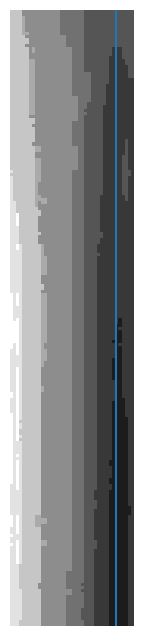

In [14]:
ax = frame_plt_vis(out_im, fsize = (8, 8))
ax.axvline(np.argmin( np.mean(out_im, axis = 0)));


(758, 1264, 3)
(76, 126, 3)


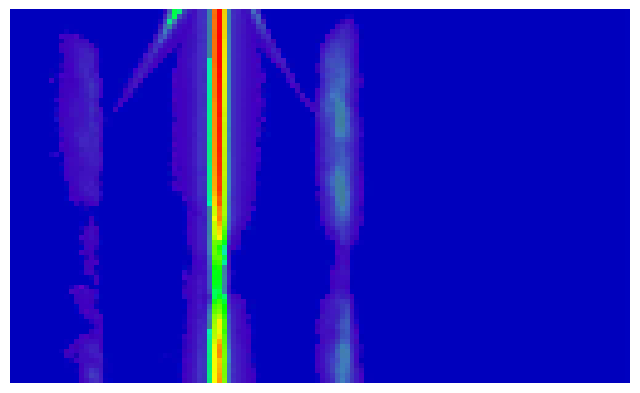

In [15]:
image = frames[0]
print(image.shape)

scale_factor = 0.1
resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
print(resized_image.shape)

frame_plt_vis(resized_image, fsize = (8, 8))
plt.show()

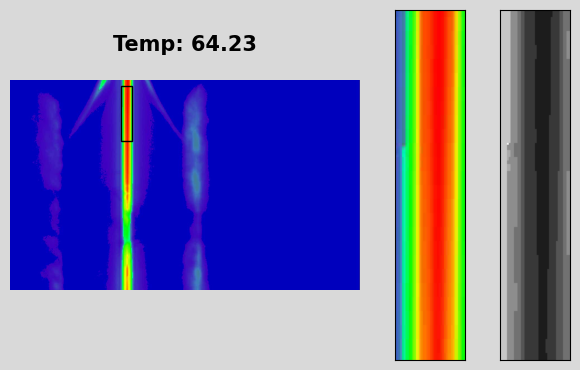

In [17]:
idn = 0
image = frames[idn+0]
xycoord = (400, 20)
w ,h = 40, 200
cropped_image = image[xycoord[1]:xycoord[1]+h, xycoord[0]:xycoord[0]+w]

out_im = get_gray_scale_image(cropped_image, colors_to_gray)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 6), facecolor='.85')

ax1.set_position([0.05, 0.05, 0.5, 0.9])  # (left, bottom, width, height)
ax2.set_position([0.6, 0.05, 0.1, 0.9])   
ax3.set_position([0.75, 0.05, 0.1, 0.9])   

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
rectangle = patches.Rectangle(xycoord, w, h, linewidth=1, edgecolor='black', facecolor='none') # bottom left corner | w, h
ax1.add_patch(rectangle)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(cv2.cvtColor(out_im, cv2.COLOR_BGR2RGB))
ax3.set_xticks([])
ax3.set_yticks([])

temp = obtain_temp(out_im)
f.suptitle(f'Temp: {temp:.2f}',fontsize=15, x=0.3,y=.75, weight='semibold')

plt.show()

[  0  39  79 119 159 199]


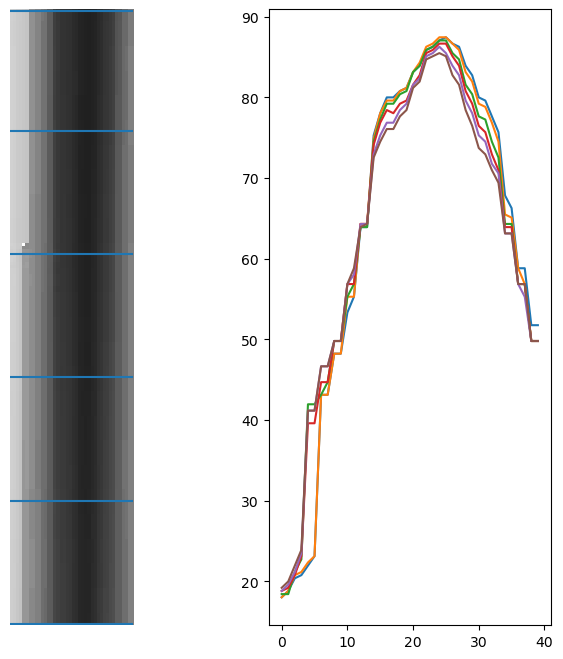

In [63]:
colors_to_gray = get_colors_to_gray(250)
out_im = get_gray_scale_image(cropped_image, colors_to_gray)

indexes = np.linspace(0,out_im.shape[0]-1, 6).astype(int)
print(indexes)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(cv2.cvtColor(out_im, cv2.COLOR_BGR2RGB))

for i in indexes:
    ax1.axhline(i)
    temps = -(100/255)*out_im[i, :]+100
    ax2.plot(temps)

ax1.axis('off')

plt.show()